# Cohort Anomalies

- Identify anomalies and metrics in student access to the Codeup Curriculum

## Goal

Identify:
* most and least popular lessons
* less active students
* suspicious activity
* frequently referenced topics

In [1]:
# local imports
import wrangle as w
import explore as e

## Acquire

* Data acquired from Codeup MySQL DB
* Data initially acquired on 14 June 2023
* Dataset shape before cleaning:
    * 900,222 rows and 8 columns
* Each row represents a user from a cohort in a Codeup program accessed a specified path to the curriculum
* Each column represents an element of the access, such as date, time, path, etc.

## Prepare

**Prepare Actions**:

* Renamed columns to promote readability and merging
* Removed columns
    - too many null values
    - duplicated information
* Removed nulls
* Checked that column data types were appropriate
* Created custom features to help investigate

In [2]:
# acquire, clean, and prepare the data
df = w.wrangle_logs()

#### A brief look at the data

In [3]:
df.head()

,path,user_id,cohort_id,ip,name,start_date,end_date,program_id
datetime,,,,,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2.0


## Explore

1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?
2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?
3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?
4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?
5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?
6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?
7. Which lessons are least accessed?

### 1) Which lesson appears to attract the most traffic consistently across cohorts (per program)?

**Web Dev**: javascript-i/introduction/working-with-data-types-operators-and-variables

**Data Science**: classification/overview

In [4]:
# web dev and data science lessons with most traffic
e.question1(df)

Web Dev
lesson: javascript-i/introduction/working-with-data-types-operators-and-variables
count: 6809

Data Science
lesson: classification/overview
count: 1785


### 2) Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

Darden accessed the classification/overview lesson almost 2x as many as the other cohorts combined

In [5]:
# show cohort access counts for a lesson
e.question2(df)

,name,path,path_count
11445,Darden,classification/overview,1109
11721,Easley,classification/overview,445
11067,Curie,classification/overview,136
11914,Florence,classification/overview,60
10618,Bayes,classification/overview,35
7780,Teddy,classification/overview,1


### 3) Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

Yes, there were students who accessed the curriculum less often than there were days in the program they were in. Most were from web dev, in cohorts Oberon, Neptune, and Sequoia. It is possible that some of these students were not able to finish the course and dropped out.

Top Cohorts with # of less active students
Oberon     26
Neptune    21
Sequoia    16
Name: name, dtype: int64


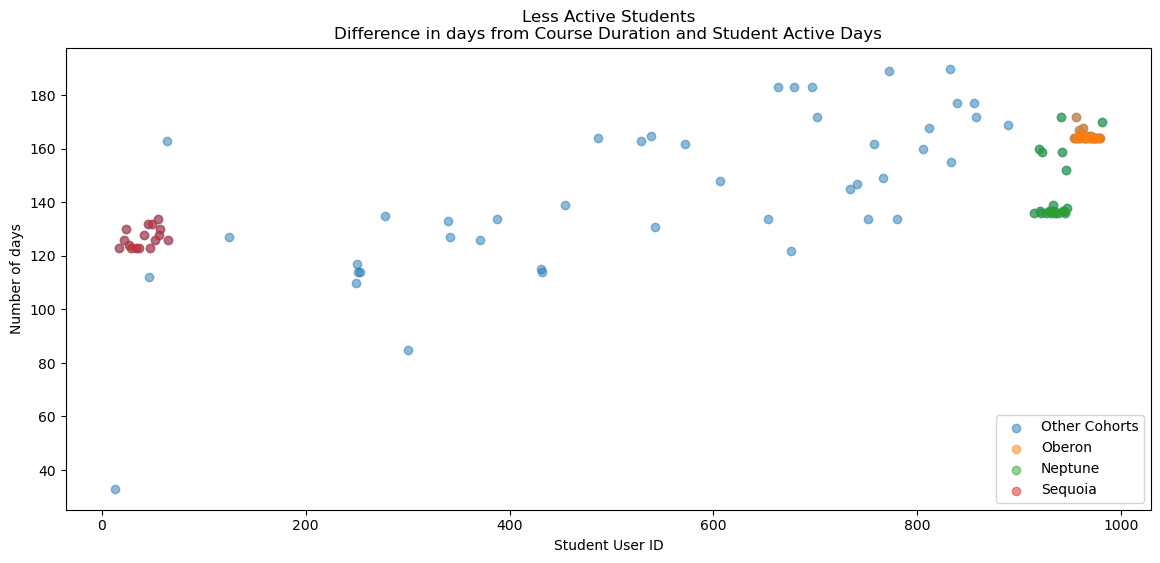

In [6]:
# show less active students with top cohorts highlighted
e.question3(df,True)

### 4) Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?


In [8]:
# 
# e.question4(df)

### 5) At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

Before the shut off, there were some students accessing the curriculum of both programs. After the shut off, it seemed that of the few students that were trying to access another program's curriculum, most were web dev students.

In [9]:
# data science paths accessed by web dev students
e.question5(df,'wd')

,datetime,path,program_id
341591,2019-12-22 19:41:44,1-fundamentals/1.2-data-science-pipeline,2.0
341596,2019-12-22 19:44:37,1-fundamentals/1.2-data-science-pipeline,2.0
347473,2020-01-13 15:00:39,1-fundamentals/1.1-intro-to-data-science,2.0
347479,2020-01-13 15:02:29,1-fundamentals/1.1-intro-to-data-science,2.0
347510,2020-01-13 15:18:55,1-fundamentals/1.1-intro-to-data-science,2.0
347512,2020-01-13 15:18:58,1-fundamentals/1.1-intro-to-data-science,2.0
347515,2020-01-13 15:19:08,1-fundamentals/1.2-data-science-pipeline,2.0
561978,2020-11-10 10:14:09,fundamentals/intro-to-data-science,2.0
566557,2020-11-17 08:40:22,fundamentals/intro-to-data-science,2.0
581781,2020-12-08 15:28:58,fundamentals/intro-to-data-science,2.0


In [10]:
# java/javascript paths accessed by data science students
e.question5(df,'ds')

,datetime,path,program_id
330331,2019-12-03 11:49:29,javascript-i,3.0
330334,2019-12-03 11:49:33,javascript-ii,3.0
330335,2019-12-03 11:49:35,java-ii,3.0
336295,2019-12-14 16:46:24,javascript-i,3.0
440517,2020-05-19 16:03:32,java-ii/object-oriented-programming,3.0


### 6) What topics are grads continuing to reference after graduation and into their jobs (for each program)?


In [11]:
# 
# e.question6(df)

### 7) Which lessons are least accessed?

In [12]:
# 
# e.question7(df)

## Exploration Summary

- All time most referenced lesson per Program:
    - **Web Dev**: Javascript-I – Intro – Working with Data Types, Operators, and Variables
    - **Data Science**: Classification – Overview (referenced mostly by Darden Cohort)
- Top 3 referenced topics per Program after graduation:
    - **Web Dev**: Spring, Javascript-I, and HTML-CSS
    - **Data Science**: SQL, Fundamentals, and Classification
- There were some students who accessed the curriculum less often than there were days in the program they were in. Most were from web dev, in cohorts Oberon, Neptune, and Sequoia. It is possible that some of these students were not able to finish the course and dropped out.
- Before the cross-curriculum access was shut off, there were some students accessing the curriculum of both programs. After the shut off, it seemed that of the few students that were trying to access another program's curriculum, most were web dev students.


## Conclusion

### Takeaways and Key Findings
* ...

### Recommendations and Next Steps
* ...